In [4]:
%matplotlib inline
from __future__ import division
import numpy as np
import os
import sys
import datetime
from subprocess import call
import subprocess
import glob
import djPyi2 as DJ
from djPyi2 import Common as CM
from djPyi2 import mpltools

from matplotlib_venn import venn2, venn2_circles, venn3, venn3_circles
import pandas as pd
import csv
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import copy 
import pybedtools as pbt
import ciepy
import cardipspy as cpy
import itertools
import tempfile
import six
import networkx as nx
import scipy.stats as stats
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)
from mpl_toolkits.axes_grid1 import  make_axes_locatable
import datetime

from scipy.stats import mode
dy_name = 'gs_qc_analysis_final'

private_out = os.path.join(DJ.root, 'private_output', dy_name)
if not os.path.exists(private_out):
    cpy.makedir(private_out)

# Test Replication Rate versus VCF annotations in GS Variants

In [54]:
def filtering_df(rr_df, info, cat, thresholds, subcat = False):
    
    def add_num_sites_total(df, info, thresholds, subcat=False):
        data = []
        for i in thresholds:
            if subcat:
                s =  info[(info[cat] >= i) & (info['SVTYPE'] == subcat)].shape[0]
            else:
                s = info[info[cat] >= i].shape[0]
            data.append(s)
        df = df.copy()
        df['num_sites_all'] = data
        return df
    
   
    dfs = []
    
    for g, df in rr_df.groupby('SVTYPE'):
        data = []
        for thresh in thresholds:
            tdf = df[(df[cat] >= thresh) & (df.replication_rate != 'None')]
            m = tdf.replication_rate.astype(float).mean()
            s = tdf.shape[0]
            data.append([thresh, s, m, g])
    
    
            
        filtDf = pd.DataFrame(data, columns=['thresh', 'num_sites', 'mean_replication_rate', 'SVTYPE'])
        filtDf = filtDf.pipe(add_num_sites_total, info, thresholds, subcat=g)
        dfs.append(filtDf)
    
    # with no subtypes
    data = []
    for thresh in thresholds:
        tdf = rr_df[(rr_df[cat] >= thresh) & (rr_df.replication_rate != 'None')]
        m = tdf.replication_rate.astype(float).mean()
        s = tdf.shape[0]
        data.append([thresh, s, m, 'all'])
    filtDf = pd.DataFrame(data, columns=['thresh', 'num_sites', 'mean_replication_rate', 'SVTYPE'])
    filtDf = filtDf.pipe(add_num_sites_total, info, thresholds, subcat=False)
        
    dfs.append(filtDf)
    df_out = pd.concat(dfs)
    

        
    return df_out 

In [7]:
def plot_discordance_vs_cat(df,labels, colors, thresholds, thresholds_ticks, num_sites, cat, letter, line_height=0.9):
    min_thresh = min(thresholds)
    max_thresh = max(thresholds)
    
    
    with sns.axes_style('ticks'):
        fig, ax = plt.subplots(1,1, figsize = (8,5))
        
        # color bar plotting
        divider = make_axes_locatable(ax)
        axDivY = divider.append_axes( 'right', size=0.2, pad= 0.1)
        cmap = plt.cm.PuBu
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min_thresh, vmax=max_thresh))
        sm.set_array([]) 
        cbar = plt.colorbar(sm, cax = axDivY)
        cbar.set_ticks(thresholds_ticks)
        
        patches = mpltools.get_legend_patches(labels, markeredgecolor=colors,
                                     markerfacecolor='white', markeredgewidth=2, markersize=10)
        
         
        
        for c, l in zip(colors, labels):
            tdf = df[df.SVTYPE == l]
         
            ax.scatter(tdf[num_sites], tdf.mean_replication_rate, 
                       c = tdf.thresh, cmap= cmap, lw = 1, edgecolor = c, label = l)
            
        leg = ax.legend(handles = patches, bbox_to_anchor = (1,0), loc='lower right',ncol = 1,
                             fontsize= 11, title = 'SVTYPE', frameon=True, borderaxespad=0)
        leg.get_frame().set_facecolor('white')
        leg.get_frame().set_edgecolor('black')
        plt.setp(leg.get_title(), fontsize=12, color='Black')
        
        ax.set(ylabel = 'mean replication rate', xlabel = 'number of total sites')      
        fig.text(0.98, 0.5, "{} threshold".format(cat), 
                 rotation= 90, horizontalalignment='center', verticalalignment='center', fontsize = 15)
        
        
        xlim = ax.get_xlim()

        ax.axhline(line_height, 0, 1, linestyle = '--')
        return ax
        

In [89]:
def prep_rr_df(df, info):
    df = df.copy()
    if 'SVTYPE' in df.columns:
        df = df.drop('SVTYPE', axis = 1)
    
    df = df.join(info.GSCNQUAL.astype(float))
    df['SVTYPE'] = info.cnv_class
    df = df[df['name'].isin(info.index.tolist())]
    
    return df

In [9]:
def prep_info(df):
    df = df.copy()
    df.SVTYPE = df.cnv_class
    df = df[df.cnv_class != 'Non_Bi']
    try:
        df = df[df.somatic == False]
    except:
        pass
    df.GSCNQUAL = df.GSCNQUAL.astype(float)

    return df

In [10]:
def get_rr_per_pair_summary(df):
    
    df = df.copy()
    if 'ID' in df.columns:
        df = df.drop('ID', axis = 1)
        
    df = df.apply(pd.value_counts).T.stack().to_frame('counts').reset_index()
    names = ['pair', 'category', 'counts']
    df.columns = names
    df = df.pivot_table(values = 'counts', index = 'pair', columns = ['category'])
    
    for c in df.columns:
        df[c] = df[c].fillna(0).astype(int)
    
    df['total_variants'] = df.CONCORDANT + df.DISCORDANT
    df['percent_concordant'] = df.CONCORDANT/ df.total_variants
    return df

In [11]:
gs_info_annot = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/gs_processing_V4/ipscore/gs_info_annot.pkl').pipe(prep_info)

In [49]:
gs_info_annot['alleles_str'] = gs_info_annot.variant_alleles.apply(lambda x: ",".join(map(str,x)))

In [90]:
rr_per_site_twins = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/gs_processing_V4/ipscore/rr_per_site_twins.pkl').pipe(prep_rr_df, gs_info_annot)

In [135]:
info_hipsci = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/gs_processing_V4/hipsci_fib/gs_info_annot.pkl').pipe(prep_info)

rr_per_site_fib_ipsc = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/gs_processing_V4/i2QTL_rr/hipsci_fib/rr_per_site_fib_ipsc_nlq.pkl').pipe(prep_rr_df, info_hipsci)


# rr_per_site_fib_ipsc = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/gs_processing_V4/hipsci_fib/rr_per_site_fib_ipsc.pkl').pipe(prep_rr_df, info_hipsci)

In [122]:
# best 152 pairs
rr_per_site_fib_ipsc_filt = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/gs_processing_V4/i2QTL_rr/hipsci_fib/rr_per_site_fib_ipsc_bp_nlq.pkl').pipe(prep_rr_df, info_hipsci)

In [93]:
rr_per_pair_fib_ipsc = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/gs_processing_V4/hipsci_fib/rr_per_pair_fib_ipsc.pkl')

rr_per_pair_twins = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/gs_processing_V4/ipscore/rr_per_pair_twins.pkl')

In [94]:
rr_summary_fib_ipsc = get_rr_per_pair_summary(rr_per_pair_fib_ipsc)

In [95]:
rr_summary_twins = get_rr_per_pair_summary(rr_per_pair_twins)

Text(0,0.5,'count')

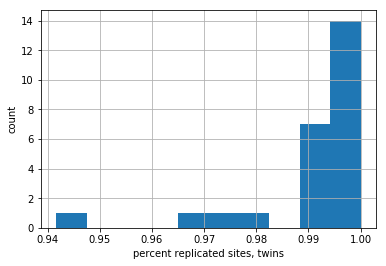

In [18]:
rr_summary_twins.percent_concordant.hist()
plt.xlabel('percent replicated sites, twins')
plt.ylabel('count')

Text(0,0.5,'count')

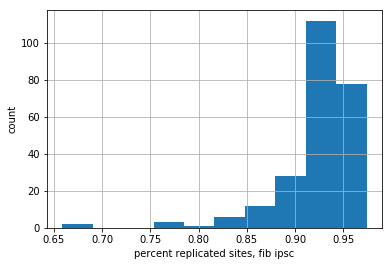

In [19]:
rr_summary_fib_ipsc.percent_concordant.hist()
plt.xlabel('percent replicated sites, fib ipsc')
plt.ylabel('count')

a few of the hipsci fib-ipsc pairs probably have considerable somatic variation between them, affected the percentage of concordance between them in genotypes

In [108]:
thresholds_gsnqual = list(np.arange(0, 100, 2))
thresholds_gsnqual_ticks = list(np.arange(0, 100, 5))
fdf = filtering_df(rr_per_site_twins, gs_info_annot, 'GSCNQUAL', thresholds_gsnqual)

In [136]:
fdf_hipsci =  filtering_df(rr_per_site_fib_ipsc, info_hipsci, 'GSCNQUAL', thresholds_gsnqual)

In [137]:
fdf_fib_ipsc_filt = filtering_df(rr_per_site_fib_ipsc_filt, info_hipsci, 'GSCNQUAL', thresholds_gsnqual)

In [81]:
CM.save_dataframe('gs_rr_MSQ_twins', fdf, private_out)

gs_rr_MSQ_twins = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/gs_qc_analysis_final/gs_rr_MSQ_twins.pkl')
gs_rr_MSQ_twins = pd.read_csv('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/gs_qc_analysis_final/gs_rr_MSQ_twins.tsv', sep='\t')
# all vars recorded: /frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/gs_qc_analysis_final/load_saved_nb_variables.py
# pickled vars recorded:/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/gs_qc_analysis_final/load_pickled_nb_variables.py


In [82]:
CM.save_dataframe('gs_rr_MSQ_ipsc_fib_filt_bp', fdf_fib_ipsc_filt, private_out)

gs_rr_MSQ_ipsc_fib_filt_bp = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/gs_qc_analysis_final/gs_rr_MSQ_ipsc_fib_filt_bp.pkl')
gs_rr_MSQ_ipsc_fib_filt_bp = pd.read_csv('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/gs_qc_analysis_final/gs_rr_MSQ_ipsc_fib_filt_bp.tsv', sep='\t')
# all vars recorded: /frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/gs_qc_analysis_final/load_saved_nb_variables.py
# pickled vars recorded:/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/gs_qc_analysis_final/load_pickled_nb_variables.py


In [83]:
CM.save_dataframe('gs_rr_MSQ_ipsc_fib', fdf_hipsci, private_out)

gs_rr_MSQ_ipsc_fib = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/gs_qc_analysis_final/gs_rr_MSQ_ipsc_fib.pkl')
gs_rr_MSQ_ipsc_fib = pd.read_csv('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/gs_qc_analysis_final/gs_rr_MSQ_ipsc_fib.tsv', sep='\t')
# all vars recorded: /frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/gs_qc_analysis_final/load_saved_nb_variables.py
# pickled vars recorded:/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/gs_qc_analysis_final/load_pickled_nb_variables.py


In [112]:
colors = ['#d11141', '#00b159', '#f37735', 'black']
labels = ['DEL', 'DUP', 'mCNV', 'all']

In [113]:
def annotate_arrows(ax, unit, offset, fdf, thresh_del, thresh_dup, thresh_mcnv):
    
    

    filter_levels = [thresh_del, thresh_dup, thresh_mcnv]
    categories = ['DEL', 'DUP', 'mCNV', 'all']
    colors = ['#d11141', '#00b159', '#f37735', 'black']
    
    for fl, cat, c in zip(filter_levels, categories, colors):
        x_coord, y_coord = fdf[(fdf.SVTYPE == cat) & (fdf.thresh==fl)][['num_sites_all', 'mean_replication_rate']].values[0]
        
#         x_coord, y_coord = df[df.thresh==fl][['num_sites_all', 'mean_replication_rate']].values[0]
        x_coord += offset
        x_coord2 = x_coord + unit
        
        ax.annotate('', xy=(x_coord, y_coord), xytext=(x_coord2, y_coord), arrowprops=dict(facecolor='black', width=1, shrink = 0.0, headwidth=8, color = c))

In [114]:
# filtering conditions setting a minimum filter at 20

filters = fdf[fdf.mean_replication_rate > 0.99].groupby('SVTYPE').thresh.min().to_dict()
filters = {k:(v if v!= 0 else 0) for k,v in filters.iteritems()}

In [115]:
def select_filters(fdf):
    filters = fdf[fdf.mean_replication_rate > 0.99].groupby('SVTYPE').thresh.min().to_dict()
    filters = {k:(v if v!= 0 else 0) for k,v in filters.iteritems()}
    fdf_filt = fdf.copy()
    for k,v in filters.iteritems():
        fdf_filt = fdf_filt[~((fdf_filt.SVTYPE==k) & (fdf_filt.thresh != v))]
    return fdf_filt, filters

In [72]:
# gs_info_annot[gs_info_annot.Chr.isin(CM.normal_Chrs[-2:])].groupby(("Chr","SVTYPE")).alleles_str.value_counts()

In [103]:
fdf_filt, filters = select_filters(fdf)

/frazer01/home/djakubosky/software/anaconda/lib/python2.7/site-packages/matplotlib/patches.py:83: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"
/frazer01/home/djakubosky/software/anaconda/lib/python2.7/site-packages/matplotlib/patches.py:83: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"
/frazer01/home/djakubosky/software/anaconda/lib/python2.7/site-packages/matplotlib/patches.py:83: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"


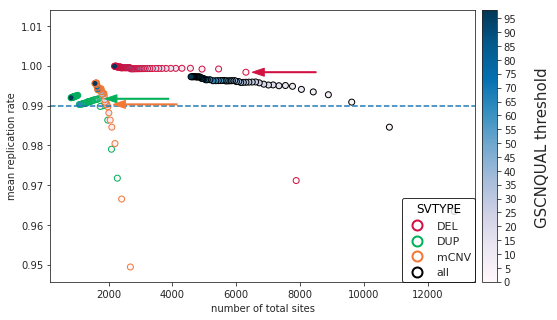

In [78]:
ax = plot_discordance_vs_cat(fdf, labels, colors, thresholds_gsnqual,thresholds_gsnqual_ticks, 'num_sites_all', 'GSCNQUAL', 'A', line_height=0.99)
annotate_arrows(ax, 2000, 200, fdf, 2, 12, 14)
# ax.axhline(1, 0, 3000, linestyle = '--')

/frazer01/home/djakubosky/software/anaconda/lib/python2.7/site-packages/matplotlib/patches.py:83: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"
/frazer01/home/djakubosky/software/anaconda/lib/python2.7/site-packages/matplotlib/patches.py:83: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"
/frazer01/home/djakubosky/software/anaconda/lib/python2.7/site-packages/matplotlib/patches.py:83: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"


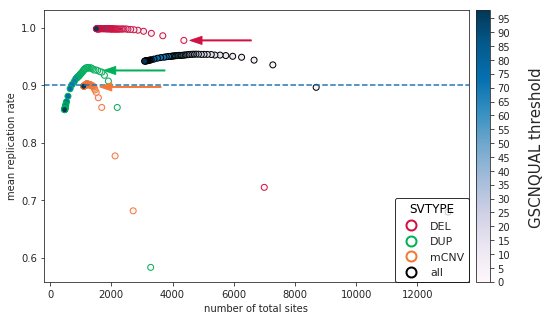

In [138]:
ax = plot_discordance_vs_cat(fdf_hipsci, labels, colors, thresholds_gsnqual, thresholds_gsnqual_ticks, 'num_sites_all', 'GSCNQUAL', 'B', line_height=0.9)
annotate_arrows(ax, 2000, 200, fdf_hipsci, 2, 12, 14)

/frazer01/home/djakubosky/software/anaconda/lib/python2.7/site-packages/matplotlib/patches.py:83: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"
/frazer01/home/djakubosky/software/anaconda/lib/python2.7/site-packages/matplotlib/patches.py:83: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"
/frazer01/home/djakubosky/software/anaconda/lib/python2.7/site-packages/matplotlib/patches.py:83: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"
/frazer01/home/djakubosky/software/anaconda/lib/python2.7/site-packages/matplotlib/patches.py:83: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property

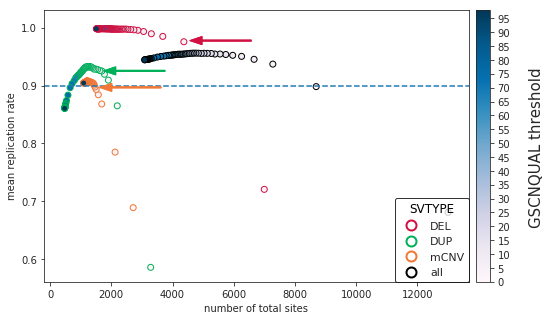

In [125]:
ax = plot_discordance_vs_cat(fdf_fib_ipsc_filt, labels, colors, thresholds_gsnqual, thresholds_gsnqual_ticks, 'num_sites_all', 'GSCNQUAL', 'B', line_height=0.9)
annotate_arrows(ax, 2000, 200, fdf_hipsci, 2, 12, 14)
annotate_arrows(ax, 2000, 200, fdf_hipsci, 2, 12, 14)

/frazer01/home/djakubosky/software/anaconda/lib/python2.7/site-packages/matplotlib/patches.py:83: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"
/frazer01/home/djakubosky/software/anaconda/lib/python2.7/site-packages/matplotlib/patches.py:83: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"
/frazer01/home/djakubosky/software/anaconda/lib/python2.7/site-packages/matplotlib/patches.py:83: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"


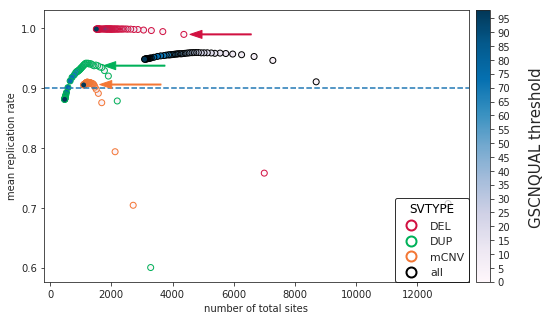

In [79]:
ax = plot_discordance_vs_cat(fdf_hipsci, labels, colors, thresholds_gsnqual, thresholds_gsnqual_ticks, 'num_sites_all', 'GSCNQUAL', 'B', line_height=0.9)
annotate_arrows(ax, 2000, 200, fdf_hipsci, 2, 12, 14)

/frazer01/home/djakubosky/software/anaconda/lib/python2.7/site-packages/matplotlib/patches.py:83: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"
/frazer01/home/djakubosky/software/anaconda/lib/python2.7/site-packages/matplotlib/patches.py:83: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"
/frazer01/home/djakubosky/software/anaconda/lib/python2.7/site-packages/matplotlib/patches.py:83: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"


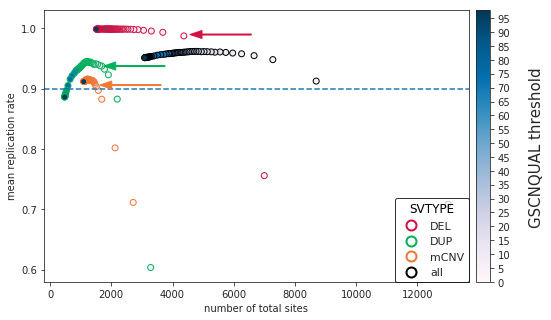

In [80]:
ax = plot_discordance_vs_cat(fdf_fib_ipsc_filt, labels, colors, thresholds_gsnqual, thresholds_gsnqual_ticks, 'num_sites_all', 'GSCNQUAL', 'B', line_height=0.9)
annotate_arrows(ax, 2000, 200, fdf_hipsci, 2, 12, 14)